# Programming assignment 2: Recurrent Neural Networks and Transformer

## Overview

<font size='4'>In this assignment you will practice putting together implementations of Recurrent Neural Networks, Transformer (encoder and decoder), and their applications to text classification, image classification, and text generation (machine translation). Especially for Transformer, you will get good understandings about foundations for very state-of-the-art models that you likely to see in tech news articles nowadays, like GPT-3, CLIP, or VisionTransformer.</font>

## Submission format

- <font size='4'>`<your_nu_username>_rnn_transformer.ipynb` with your implementations and output.</font>

## Note

<font size='4'>  
- You do not need to tune hyper parameters in the regular tasks.

- You do not install any additional packages inside the Colab environment. Do not forget to choose to use GPU in the `Runtime\Change runtime type` tab.    

- **You are not allowed to consult any online resources except for the links provided in this assignment.**

- **Violation of this policy will lead to failure of your course and even more severe consequences.**

- Attend office hours and make post on Piazza if you have any questions.

- You have sufficient time to work on this assignment. Please refrain from asking for extensions.

- The thrid programming assignment is optional but you may earn extra credits out it. Plan wisely as its deadline may approach the end of this semester, where there are a lot of deadlines around.
</font>


## Setup

In [2]:
# ==================
# ATTENTION:
# For the first time, uncomment the following lines and re-run the cell.
# You may have to hit the "RESTART RUNTIME" button in the output and then re-run this cell.
# Once it is done, you can comment the following lines and run other cells.
# ==================

# # Create source and target language tokenizer. Make sure to install the dependencies.
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!pip uninstall -y torch torchdata torchvision torchtext torchaudio fastai
!pip install portalocker
!pip install --pre torch torchdata -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-04-11 04:42:04.283500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 04:42:05.262346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-11 04:42:06.573021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-11 04:42:06.573513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA 

## Part 1: Text Classification with RNN (24 points)

In [3]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchtext.datasets import AG_NEWS
train_iter = AG_NEWS(split='train')

# Let's check what the data looks like
print(len(list(train_iter)))
print(next(iter(train_iter)))

120000
(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


### <font size='4' color='red'>Task 1.1: Implement a RNNCell (4 points)</font>

In [4]:
# Documentation of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class RNNCell(torch.nn.Module):
    """
    RNNCell is a single cell that takes x_t and h_{t_1} as input and outputs h_t.
    """
    def __init__(self, input_dim: int, hidden_dim: int):
        """
        Constructor of RNNCell.
        
        Inputs: 
        - input_dim: Dimension of the input x_t
        - hidden_dim: Dimension of the hidden state h_{t-1} and h_t
        """
        
        # We always need to do this step to properly implement the constructor
        super(RNNCell, self).__init__()
        
        self.linear_x, self.linear_h, self.non_linear = None, None, None  
        
        ###########################################################################
        # TODO: Define the linear transformation layers for x_t and h_{t-1} and   #
        # the non-linear layer. You can use tanh here.                            #
        ###########################################################################

        # x_t, input at current time step
        self.linear_x = nn.Linear(input_dim, hidden_dim)
        # h_{t-1}, input at previous time step
        self.linear_h = nn.Linear(hidden_dim, hidden_dim)
        # non-linear activation, tanh
        self.non_linear = nn.Tanh()

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x_cur: torch.Tensor, h_prev: torch.Tensor):
        """
        Compute h_t given x_t and h_{t-1}.
        
        Inputs:
        - x_cur: x_t, a tensor with the same of BxC, where B is the batch size and 
          C is the channel dimension.
        - h_prev: h_{t-1}, a tensor with the same of BxH, where H is the channel
          dimension.
        """
        h_cur = None
        ###########################################################################
        # TODO: Define the linear transformation layers for x_t and h_{t-1} and   #
        # the non-linear layer.                                                   #
        ###########################################################################
        
        # transform the inputs and send through activation function
        x = self.linear_x(x_cur)
        h = self.linear_h(h_prev)
        h_cur = self.non_linear(x+h)
        
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return h_cur

In [5]:
# Let's run a sanity check of your model
x = torch.randn((2, 8))
h = torch.randn((2, 16))
model = RNNCell(8, 16)
y = model(x, h)
assert len(y.shape) == 2 and y.shape[0] == 2 and y.shape[1] == 16
print(y.shape)

torch.Size([2, 16])


### <font size='4' color='red'>Task 1.2: Implement a single-layer (single-stack) RNN (5 points)</font>

In [6]:
class RNN(torch.nn.Module):
    """
    RNN is a single-layer (stack) RNN by connecting multiple RNNCell together in a single
    direction, where the input sequence is processed from left to right.
    """
    def __init__(self, input_dim: int, hidden_dim: int):
        """
        Constructor of the RNN module.
        
        Inputs: 
        - input_dim: Dimension of the input x_t
        - hidden_dim: Dimension of the hidden state h_{t-1} and h_t
        """
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        ###########################################################################
        # TODO: Define the RNNCell.                                               #
        ###########################################################################
        
        # defining the RNNCell class from earlier
        self.RNNCell = RNNCell(input_dim, hidden_dim)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x: torch.Tensor):
        """
        Compute the hidden representations for every token in the input sequence.
        
        Input:
        - x: A tensor with the shape of BxLxC, where B is the batch size, L is the squence 
          length, and C is the channel dimmension
          
        Return:
        - h: A tensor with the shape of BxLxH, where H is the hidden dimension of RNNCell
        """
        b = x.shape[0]
        seq_len = x.shape[1]
        
        # initialize the hidden dimension
        init_h = x.new_zeros((b, self.hidden_dim))
        
        h = None
        ###########################################################################
        # TODO: Compute the hidden representation for every token in the input    #
        # from left to right.
        ###########################################################################
        
        hState = []

        for timestep in range(seq_len):
          # current input element
          tInput = x[:, timestep, :]
          # compute current hidden state
          if timestep == 0:
            cHidden = self.RNNCell(tInput, init_h)
          else:
            cHidden = self.RNNCell(tInput, pHidden)
          # store hidden state
          hState.append(cHidden)
          # update previous hidden state
          pHidden = cHidden
          
        # stack hidden states along the sequence(1) dimension
        h = torch.stack(hState, dim=1)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return h
        

In [7]:
# Let's run a sanity check of your model
x = torch.randn((2, 10, 8))
model = RNN(8, 16)
y = model(x)
assert len(y.shape) == 3
for dim, dim_gt in zip(y.shape, [2, 10, 16]):
    assert dim == dim_gt
print(y.shape)

torch.Size([2, 10, 16])


### <font size='4' color='red'>Task 1.3: Implement a RNN-based text classifier (4 points)</font>

In [8]:
class RNNClassifier(nn.Module):
    """
    A RNN-based classifier for text classification. It first converts tokens into word embeddings.
    And then feeds the embeddings into a RNN, where the hidden representations of all tokens are
    then averaged to get a single embedding of the sentence. It will be used as input to a linear
    classifier.
    """
    def __init__(self, 
            vocab_size: int, embed_dim: int, rnn_hidden_dim: int, num_class: int, pad_token: int
        ):
        """
        Constructor.
        
        Inputs:
        - vocab_size: Vocabulary size, indicating how many tokens we have in total.
        - embed_dim: The dimension of word embeddings
        - rnn_hidden_dim: The hidden dimension of the RNN.
        - num_class: Number of classes.
        - pad_token: The index of the padding token.
        """
        super(RNNClassifier, self).__init__()
        
        # word embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_token)
        
        self.rnn, self.fc = None, None
        
        ###########################################################################
        # TODO: Define the RNN and the classification layer.                      #
        ###########################################################################
        
        self.RNN = RNN(embed_dim, rnn_hidden_dim)
        # linear classifier
        self.lin = nn.Linear(rnn_hidden_dim, num_class)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        """
        Get classification scores (logits) of the input.
        
        Input:
        - text: Tensor with the shape of BxLxC.
        
        Return:
        - logits: Tensor with the shape of BxK, where K is the number of classes
        """
        
        # get word embeddings
        embedded = self.embedding(text)
        
        logits = None
        ###########################################################################
        # TODO: Compute logits of the input.                                      #
        ###########################################################################
        
        # send word embeddings through RNN
        RNNoutput = self.RNN(embedded)
        # average along hidden dim(1)
        AVGoutput = torch.mean(RNNoutput, dim=1)
        # get logitcs through fc
        logits = self.lin(AVGoutput)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return logits

In [9]:
# Let's run a sanity check of your model
vocab_size = 10
embed_dim = 16
rnn_hidden_dim = 32
num_class = 3

x = torch.arange(vocab_size).view(1, -1)
x = torch.cat((x, x), dim=0)
print('x.shape: {}'.format(x.shape))
model = RNNClassifier(vocab_size, embed_dim, rnn_hidden_dim, num_class, 0)
y = model(x)
assert len(y.shape) == 2 and y.shape[0] == 2 and y.shape[1] == num_class
print(y.shape)

model = model.to('cuda:0')
x = x.to('cuda:0')
y = model(x)
print(y.shape, y.device)

x.shape: torch.Size([2, 10])
torch.Size([2, 3])
torch.Size([2, 3]) cuda:0


### Set up data related stuff

In [10]:
# check here for details https://github.com/pytorch/text/blob/main/torchtext/data/utils.py#L52-#L166
from torchtext.data.utils import get_tokenizer
# check here for details https://github.com/pytorch/text/blob/main/torchtext/vocab/vocab_factory.py#L65-L113
from torchtext.vocab import build_vocab_from_iterator

# A tokenizer splits a input setence into a set of tokens, including those puncuation
# For example
# >>> tokens = tokenizer("You can now install TorchText using pip!")
# >>> tokens
# >>> ['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']
tokenizer = get_tokenizer('basic_english')

train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Creates a vocab object which maps tokens to indices
# Check here for details https://github.com/pytorch/text/blob/main/torchtext/vocab/vocab.py
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])

# The specified token will be returned when a out-of-vocabulary token is queried.
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

# The padding token we need to use
# The returned indices are always in an array
PAD_TOKEN = vocab(tokenizer('<pad>'))
assert len(PAD_TOKEN) == 1
PAD_TOKEN = PAD_TOKEN[0]

### <font size='4' color='red'>Task 1.4: Collate Batched Data with Data Loaders (4 points)</font>

In [11]:
# Documentation of DataLoader https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
from torch.utils.data import DataLoader  

# Merges a list of samples to form a mini-batch of Tensor(s)
def collate_batch(batch):
    """
    Input: 
    - batch: A list of data in a mini batch, where the length denotes the batch size. 
      The actual context depends on a particular dataset. In our case, each position 
      contains a label and a Tensor (tokens in a sentence).
      
    Returns:
    - batched_label: A Tensor with the shape of (B,)
    - batched_text: A Tensor with the shape of (B, L, C), where L is the sequence length
      and C is the channeld dimension
    """
    label_list, text_list, text_len_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        text_len_list.append(processed_text.size(0))
    batched_label, batched_text = [], []
    # print(label_list)
    # print(text_list)
    # print(text_len_list)
    ###########################################################################
    # TODO: Pad the text tensor in the mini batch so that they have the same  #
    # length. Specifically, you need to calculate the maximum length in the   #
    # batch and then add the token PAD_TOKEN to the end of those              #
    # shorter sentences.                                                      #
    ###########################################################################
    
    # get max sentence length in the batch
    maxBatch = max(text_len_list)
    for sentenceNum in range(len(text_list)):
      # if the length is shorter than max, find difference and pad
      if text_len_list[sentenceNum] < maxBatch:
        difference = maxBatch - text_len_list[sentenceNum]
        batched_text.append(torch.cat([text_list[sentenceNum], torch.tensor([PAD_TOKEN] * difference)]))
      else:
        batched_text.append(text_list[sentenceNum])
      batched_label.append(label_list[sentenceNum])

    # convert to tensors 
    batched_label = torch.tensor(batched_label)
    batched_text = torch.stack(batched_text)
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return batched_label.long(), batched_text.long()

# Now, let's check what the batched data looks like
train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)
for idx, (label, data) in enumerate(dataloader):
    if idx > 0:
        break
    print('label.shape: {}'.format(label.shape))
    print('label: {}'.format(label))
    print('data.shape: {}'.format(data.shape))

label.shape: torch.Size([8])
label: tensor([2, 2, 2, 2, 2, 2, 2, 2])
data.shape: torch.Size([8, 49])


### <font size='4' color='red'>Task 1.5: Functions of training for a single epoch and evaluation (4 points)</font>

In [12]:
import time

def train(model, dataloader, loss_func, device, grad_norm_clip):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text) in enumerate(dataloader):
        label = label.to(device)
        text = text.to(device)
        optimizer.zero_grad()
        
        logits = None
        ###########################################################################
        # TODO: compute the logits of the input, get the loss, and do the         #
        # gradient backpropagation.
        ###########################################################################

        # get logits from the model
        logits = model(text)
        # get the loss
        loss = loss_func(logits, label)
        # back prop
        loss.backward()

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        total_acc += (logits.argmax(1) == label).sum().item()  
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(model, dataloader, loss_func, device):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            label = label.to(device)
            text = text.to(device)
            
            ###########################################################################
            # TODO: compute the logits of the input, get the loss.                    #
            ###########################################################################

            # get logits from the model
            logits = model(text)
            # get the loss
            loss = loss_func(logits, label)
            
            ###########################################################################
            #                             END OF YOUR CODE                            #
            ###########################################################################
            
            total_acc += (logits.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

### <font size='4' color='red'>Task 1.6: Define the model and loss function to train the model (3 points)</font>

In [13]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

assert torch.cuda.is_available()
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper parameters
epochs = 3 # epoch
lr = 0.0005 # learning rate
batch_size = 64 # batch size for training
word_embed_dim = 64
rnn_hidden_dim = 96

train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)

model, loss_func = None, None
###########################################################################
# TODO: Deinfe the classifier and loss function.
###########################################################################

model = RNNClassifier(vocab_size, word_embed_dim, rnn_hidden_dim, num_class, PAD_TOKEN)
loss_func = nn.CrossEntropyLoss()

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

# copy the model to the specified device (GPU)
model = model.to(device)
        
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-8)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, 
    [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=batch_size,
    shuffle=True, collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    split_valid_, batch_size=batch_size, 
    shuffle=False, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size,
    shuffle=False, collate_fn=collate_batch
)

# You should be able get a validation accuracy around 87%
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, train_dataloader, loss_func, device, 1)
    accu_val = evaluate(model, valid_dataloader, loss_func, device)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.500
| epoch   1 |  1000/ 1782 batches | accuracy    0.725
| epoch   1 |  1500/ 1782 batches | accuracy    0.789
-----------------------------------------------------------
| end of epoch   1 | time: 84.19s | valid accuracy    0.826 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.844
| epoch   2 |  1000/ 1782 batches | accuracy    0.856
| epoch   2 |  1500/ 1782 batches | accuracy    0.868
-----------------------------------------------------------
| end of epoch   2 | time: 83.86s | valid accuracy    0.873 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.886
| epoch   3 |  1000/ 1782 batches | accuracy    0.888
| epoch   3 |  1500/ 1782 batches | accuracy    0.895
-----------------------------------------------------------
| end of epoch   3 | time: 81.85s | valid accuracy    0.886 
-------------------------------

## Part 2: Text Classification with Transformer Encoder (41 points)

### <font size='4' color='red'>Task 2.1: Implement the multi-head attention module (no for loops allowed, 10 points)</font>

In [14]:
class MultiHeadAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors.
    """
    def __init__(self, input_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. Here we assume they all have
          the same dimensions. But they could have different dimensions in other problems.
        - num_heads: Number of attention heads
        """
        super(MultiHeadAttention, self).__init__()
        
        assert input_dim % num_heads == 0
        
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.dim_per_head = input_dim // num_heads
        
        ###########################################################################
        # TODO: Define the linear transformation layers for key, value, and query.#
        # Also define the output layer.
        ###########################################################################

        # send all the copied matrices into a fc layer, since linear output dimension is not mentioned we use input_dim itself as output(based on piazza @176)
        self.QueryLinear = nn.Linear(input_dim, input_dim)
        self.KeyLinear = nn.Linear(input_dim, input_dim)
        self.ValueLinear = nn.Linear(input_dim, input_dim)

        # output Linear
        self.outputLinear = nn.Linear(input_dim, input_dim)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - key: Tensor of the shape BxLxC
        - value: Tensor of the shape BxLxC
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]        
        
        dot_prod_scores = None
        ###########################################################################
        # TODO: Compute the scores based on dot product between transformed query,#
        # key, and value. You may find torch.matmul helpful, whose documentation  #
        # can be found at                                                         #
        # https://pytorch.org/docs/stable/generated/torch.matmul.html#torch.matmul#
        # Remember to devide the doct product similarity scores by square root of #
        # the channel dimension per head.   
        #                                                                         #
        # Since no for loops are allowed here, think of how to use tensor reshape #
        # to process multiple attention heads at the same time.                   #
        ###########################################################################
        
        # send the 3 tensors through linear layer
        QueryL = self.QueryLinear(query)
        KeyL = self.KeyLinear(key)
        ValueL = self.ValueLinear(value)

        # single head logic
        # # matmul b/n Query and Key (Q.K(transpose))
        # MatMul_QK = torch.matmul(QueryL, KeyL.transpose(-1,-2))
        # # scale b/n Query and Key, divide by square root of dim per head
        # Scale_QK = MatMul_QK / math.sqrt(self.dim_per_head)
        # # dot product scores
        # dot_prod_scores = Scale_QK

        # convert into a single multiheaded vector
        MultiQueryL = QueryL.reshape(b, -1, self.num_heads, self.dim_per_head).transpose(1,2)
        MultiKeyL = KeyL.reshape(b, -1, self.num_heads, self.dim_per_head).transpose(1,2)
        MultiValueL = ValueL.reshape(b, -1, self.num_heads, self.dim_per_head).transpose(1,2)

        # matmul(Q.K^T) and scaling(div by root Key dim)
        MatMul_QK = torch.matmul(MultiQueryL, MultiKeyL.transpose(-1,-2))
        dot_prod_scores = MatMul_QK / math.sqrt(self.dim_per_head)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        if mask is not None:
            # We simply set the similarity scores to be near zero for the positions
            # where the attention should not be done. Think of why we do this.
            dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)
        
        out = None
        ###########################################################################
        # TODO: Compute the attention scores, which are then used to modulate the #
        # value tensor. Finally concate the attended tensors from multiple heads  #
        # and feed it into the output layer. You may still find torch.matmul      #
        # helpful.                                                                #
        #                                                                         #
        # Again, think of how to use reshaping tensor to do the concatenation.    #
        ###########################################################################
        
        # softmax to normalize
        attentionScore = F.softmax(dot_prod_scores, dim=-1)
        # matmul b/n attention score and value linear
        valueTensor = torch.matmul(attentionScore, MultiValueL)
        # concatenate, step 1: transpose dim 1,2 to their original order
        valueTensor = valueTensor.transpose(1,2)
        # concatenate, step 2: merge last 2 dims
        valueTensor = valueTensor.contiguous().view(b, -1, self.input_dim)
        # send to fc
        out = self.outputLinear(valueTensor)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return out

In [15]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = MultiHeadAttention(8, num_heads)
y = model(x, x, x, mask)
assert len(y.shape) == len(x.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### <font size='4' color='red'>Task 2.2: Implement a Feedforward Network (3 points)</font>

In [16]:
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, input_dim, ff_dim, dropout):
        """
        Inputs:
        - input_dim: Input dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()
        
        ###########################################################################
        # TODO: Define the two linear layers and a non-linear one.
        ###########################################################################

        self.Lin1 = nn.Linear(input_dim, ff_dim)
        self.relu = nn.ReLU()
        self.dropout= nn.Dropout(dropout)
        self.Lin2 = nn.Linear(ff_dim, input_dim)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
         and C is the channel dimension
          
        Return:
        - y: Tensor of the shape BxLxC
        """
        
        y = None
        ###########################################################################
        # TODO: Process the input.                                                #
        ###########################################################################

        x = self.Lin1(x)
        x = self.relu(x)
        x = self.dropout(x)
        y = self.Lin2(x)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y
        

In [17]:
x = torch.randn((2, 10, 8))
ff_dim = 4
model = FeedForwardNetwork(8, ff_dim, 0.1)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### <font size='4' color='red'>Task 2.3: Implement a Single Transformer Encoder Cell (8 points)</font>

In [18]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()
        
        ###########################################################################
        # TODO: A single Transformer encoder cell consists of 
        # 1. A multi-head attention module
        # 2. Followed by dropout
        # 3. Followed by layer norm (check nn.LayerNorm)
        # https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm
        #                                                                         #
        # At the same time, it also has
        # 1. A feedforward network
        # 2. Followed by dropout
        # 3. Followed by layer norm
        ###########################################################################

        # 1st module
        self.multiHeadAttention = MultiHeadAttention(input_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.layerNorm1 = nn.LayerNorm(input_dim)
        # 2nd module
        self.feedForward = FeedForwardNetwork(input_dim, ff_dim, dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layerNorm2 = nn.LayerNorm(input_dim)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        """
        
        y = None
        ###########################################################################
        # TODO: Get the output of the multi-head attention part (with dropout     #
        # and layer norm), which is used as input to the feedforward network (    #
        # again, followed by dropout and layer norm).                             #
        #                                                                         #
        # Don't forget the residual connections for both parts.                   #
        ###########################################################################

        # 1st module/block
        # multi head attention output with dropout
        halfOut = self.dropout1(self.multiHeadAttention(x,x,x,mask))
        # add residual & norm
        normOut = self.layerNorm1(halfOut + x)

        # 2nd module/block
        # feed forward
        FFOut = self.dropout2(self.feedForward(normOut))
        # add residual & norm
        y = self.layerNorm2(FFOut + normOut)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y

In [19]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoderCell(8, num_heads, 32, 0.1)
y = model(x, mask)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### <font size='4' color='red'>Task 2.4: Implement Transformer Encoder (5 points)</font>

In [20]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        
        self.norm = None
        ###########################################################################
        # TODO: Construct a nn.ModuleList to store a stack of                     #
        # TranformerEncoderCells. Check the documentation here of how to use it   #
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList
        
        # At the same time, define a layer normalization layer to process the     #
        # output of the entire encoder.                                           #
        ###########################################################################
        
        # initialize module list
        self.moduleList = nn.ModuleList()
        # add desired number of TransformerEncoderCells
        for cell in range(num_cells):
          self.moduleList.append(TransformerEncoderCell(input_dim, num_heads, ff_dim, dropout))
        # norm layer
        self.norm = nn.LayerNorm(input_dim)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape of BxLxC, which is the normalized output of the encoder
        """
        
        y = None
        ###########################################################################
        # TODO: Feed x into the stack of TransformerEncoderCells and then         #
        # normalize the output with layer norm.                                   #
        ###########################################################################

        # feeding x through each cell 
        for module in self.moduleList:
          x = module(x,mask)
        
        # normalize
        y = self.norm(x)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y
        

In [21]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoder(8, num_heads, 32, 2, 0.1)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### <font size='4' color='red'>Task 2.5: Implement Positional Encoding (7 points)</font>

In [22]:
class PositionalEncoding(nn.Module):
    """
    A module that adds positional encoding to each of the token's features.
    So that the Transformer is position aware.
    """
    def __init__(self, input_dim: int, max_len: int=10000):
        """
        Inputs:
        - input_dim: Input dimension about the features for each token
        - max_len: The maximum sequence length
        """
        super(PositionalEncoding, self).__init__()
        
        self.input_dim = input_dim
        self.max_len = max_len
        
    def forward(self, x):
        """
        Compute the positional encoding and add it to x.
        
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
          
        Return:
        - x: Tensor of the shape BxLxC, with the positional encoding added to the input
        """
        seq_len = x.shape[1]
        input_dim = x.shape[2]
        
        ###########################################################################
        # TODO: Compute the positional encoding                                   #
        # Check Section 3.5 for the definition (https://arxiv.org/pdf/1706.03762.pdf)
        #                                                                         #
        # It's a bit messy, but the definition is provided for your here for your #
        # convenience (in LaTex).                                                 #
        # PE_{(pos,2i)} = sin(pos / 10000^{2i/\dmodel})                           #
        # PE_{(pos,2i+1)} = cos(pos / 10000^{2i/\dmodel})                         #
        #                                                                         #
        # You should replace 10000 with max_len here.
        ###########################################################################

        # tensor to hold positional encoding values, BxLxC
        pe = torch.zeros(x.shape[0], seq_len, input_dim)
        
        # double for loop logic
        # for pos in range(seq_len):
        #   for i in range(input_dim):
        #     if i % 2 != 0:
        #         pe[:, pos, i] = torch.cos(torch.tensor(pos) / self.max_len ** (i / self.input_dim)).float()
        #     else:
        #         pe[:, pos, i] = torch.sin(torch.tensor(pos) / self.max_len ** (i / self.input_dim)).float()

        posVect = torch.arange(seq_len)
        for i in range(input_dim):
          if i % 2 != 0:
            pe[:,:,i] = torch.cos(posVect * (self.max_len ** (-i / self.input_dim)))
          else:
            pe[:,:,i] = torch.sin(posVect * (self.max_len ** (-i / self.input_dim)))

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        x = x + pe.to(x.device)
        return x

In [23]:
# Sanity check
x = torch.randn(1, 100, 20)
pe = PositionalEncoding(20)
y = pe(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y

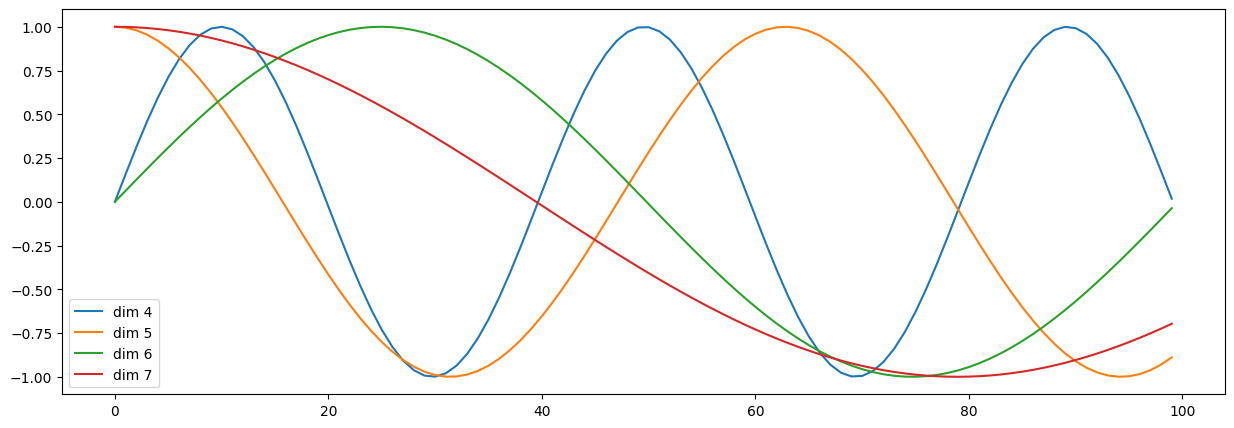

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20)
y = pe.forward((torch.zeros(5, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

### <font size='4' color='red'>Task 2.6: Implement a Transformer-based Text Classifier (5 points)</font>

In [25]:
class TransformerClassifier(nn.Module):
    """
    A Transformer-based text classifier.
    """
    def __init__(self, 
            vocab_size: int, embed_dim: int, num_heads: int, trx_ff_dim: int, 
            num_trx_cells: int, num_class: int, dropout: float=0.1, pad_token: int=0
        ):
        """
        Inputs:
        - vocab_size: Vocabulary size, indicating how many tokens we have in total.
        - embed_dim: The dimension of word embeddings
        - num_heads: Number of attention heads in a multi-head attention module
        - trx_ff_dim: The hidden dimension for a feedforward network
        - num_trx_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio
        - pad_token: The index of the padding token.
        """
        super(TransformerClassifier, self).__init__()
        
        self.embed_dim = embed_dim
        
        # word embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_token)
        
        ###########################################################################
        # TODO: Define a module for positional encoding, Transformer encoder, and #
        # a output layer                                                          #
        ###########################################################################
        
        # positional encoding
        self.pos = PositionalEncoding(embed_dim)
        # encoder
        self.encoder = TransformerEncoder(embed_dim, num_heads, trx_ff_dim, num_trx_cells, dropout)
        # linear output layer
        self.lin = nn.Linear(embed_dim, num_class)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, text, mask=None):
        """
        Inputs:
        - text: Tensor with the shape of BxLxC.
        - mask: Tensor for multi-head attention
        
        Return:
        - logits: Tensor with the shape of BxK, where K is the number of classes
        """
        
        # word embeddings, note we multiple the embeddings by a factor
        embedded = self.embedding(text) * math.sqrt(self.embed_dim)
        
        logits = None
        ###########################################################################
        # TODO: Apply positional embedding to the input, which is then fed into   #
        # the encoder. Average pooling is applied then to all the features of all #
        # tokens. Finally, the logits are computed based on the pooled features.  #
        ###########################################################################

        # add pos embedding into the word embedding
        posEmbedded = self.pos(embedded)
        # send through encoder module
        encodedWords = self.encoder(posEmbedded)
        # average pooling the feature
        avgPooledWords = torch.mean(encodedWords, dim=1)
        # computing logits
        logits = self.lin(avgPooledWords)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return logits

In [26]:
vocab_size = 10
embed_dim = 16
num_heads = 4
trx_ff_dim = 16
num_trx_cells = 2
num_class = 3

x = torch.arange(vocab_size).view(1, -1)
x = torch.cat((x, x), dim=0)
mask = (x != 0).unsqueeze(-2).unsqueeze(1)
model = TransformerClassifier(vocab_size, embed_dim, num_heads, trx_ff_dim, num_trx_cells, num_class)
print('x: {}, mask: {}'.format(x.shape, mask.shape))
y = model(x, mask)
assert len(y.shape) == 2 and y.shape[0] == x.shape[0] and y.shape[1] == num_class
print(y.shape)

x: torch.Size([2, 10]), mask: torch.Size([2, 1, 1, 10])
torch.Size([2, 3])


### <font size='4' color='red'>Task 2.7: Define the Model and Loss Function (3 points)</font>

In [27]:
assert torch.cuda.is_available()
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 5 # epoch
lr = 0.0005  # learning rate
batch_size = 64 # batch size for training
  
train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64

num_heads = 4
num_trx_cells = 2

gradient_norm_clip = 1

# adding a hidden dim variable
hid_dim = 256

###########################################################################
# Define a Transformer-based text classifier and a loss function.         #
###########################################################################

model = TransformerClassifier(vocab_size, emsize, num_heads, hid_dim, num_trx_cells, num_class)
loss_func = torch.nn.CrossEntropyLoss()

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-8)
total_accu = None

# You should be able to get a validation accuracy around 89%
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, train_dataloader, loss_func, device, gradient_norm_clip)
    accu_val = evaluate(model, valid_dataloader, loss_func, device)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.645
| epoch   1 |  1000/ 1782 batches | accuracy    0.784
| epoch   1 |  1500/ 1782 batches | accuracy    0.827
-----------------------------------------------------------
| end of epoch   1 | time: 40.22s | valid accuracy    0.846 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.869
| epoch   2 |  1000/ 1782 batches | accuracy    0.871
| epoch   2 |  1500/ 1782 batches | accuracy    0.879
-----------------------------------------------------------
| end of epoch   2 | time: 39.26s | valid accuracy    0.875 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.900
| epoch   3 |  1000/ 1782 batches | accuracy    0.900
| epoch   3 |  1500/ 1782 batches | accuracy    0.899
-----------------------------------------------------------
| end of epoch   3 | time: 39.82s | valid accuracy    0.887 
-------------------------------

## Part 3: Image Classification with Transformer (10 points)

### <font size='4' color='red'>Task 3.1: Implement VisionTransformer for Image Classification (no flor loops are allowed, 7 points)</font>

In [28]:
class VisionTransformerClassifier(nn.Module):
    """
    In the model, we partition an image into non-overlapping patches. Each patch is treated as a token.
    We can get a sequence of such tokens by flattening the patches. Each token's embeddings is the
    flattened RGB pixel values. If the patch size is 4, then the embeddings' dimension is 4*4*3.
    You can check this paper https://arxiv.org/pdf/2010.11929.pdf for reference.
    """
    def __init__(self, 
            patch_size: int, num_heads: int, trx_ff_dim: int, 
            num_trx_cells: int, num_class: int, dropout: float=0.1
        ):
        """
        Inputs:
        - patch_size: Size of the non-overlapping patches
        - num_heads: Number of attention heads
        - trx_ff_dim: Hidden dimension of the feedforward network in a Transformer encoder
        - num_trx_cells: Number of TransformerEncoderCells 
        - num_class: Number of image classes
        - dropout: Dropout ratio
        """
        super(VisionTransformerClassifier, self).__init__()
        
        self.patch_size = patch_size
        
        ###########################################################################
        # TODO: Define a TransformerEncoder that takens non-overlapping patches   #
        # of an image as input and another output layer for classification.       #
        #                                                                         #
        # Intuitively, we need 2D positional encodings for each patch according to#
        # its x and y coordinates. But this reference paper https://arxiv.org/pdf/2010.11929.pdf
        # shows there is no significance difference on accuracies. It is bit      #
        # weird. But you can simply use the 1D positional encoding you have       #
        # implemented earlier. You can experiment with 2D positional encodings    #
        # if you like to earn extra credits.                                      #
        ###########################################################################
        self.channels = 3 #since RGB
        self.embed_dim = self.patch_size * self.patch_size * self.channels

        self.encoder = TransformerEncoder(self.embed_dim, num_heads, trx_ff_dim, num_trx_cells, dropout)
        self.lin = nn.Linear(self.embed_dim, num_class)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        # def init_weights(self):
        #   initrange = 0.5
        #   self.embedding.weight.data.uniform_(-initrange, initrange)
        #   self.fc.weight.data.uniform_(-initrange, initrange)
        #   self.fc.bias.data.zero_()

    def forward(self, image: torch.Tensor):
        """
        Input:
        - image: Tensor of the shape BxCxHxW, where H and W are the height and width, respectively.
        
        Return:
        - logtis: Classification logits
        """
        
        b, c, h, w = image.shape

        ###########################################################################
        # TODO: Partition an image into non-overlapping patches. Think of how to  #
        # reshape the tensor to convert it to be the BxLxC format, which we have  #
        # extensively used for NLP tasks. You may find tensor.permute helpful.    #
        # Check documentation here https://pytorch.org/docs/stable/generated/torch.permute.html#torch.permute
        ###########################################################################
        # unfold dimension 2 (height) with size patch_size and step patch_size so it doesn't overlap
        patchTensor = image.unfold(2, self.patch_size, self.patch_size)
        # unfold along width dim 3
        patchTensor = patchTensor.unfold(3, self.patch_size, self.patch_size)
        # change dimension to BxCxPatch_sizexPatch_sizexH'xW')
        patchTensor = patchTensor.permute(0,1,4,5,2,3)
        # reshape to BxCxL
        L = (h // self.patch_size) * (w // self.patch_size)
        patchTensor = patchTensor.reshape(b,L,-1)
        #print(patchTensor.shape)
        # send the processed input into the module
        patchEncoded = self.encoder(patchTensor)
        #print(patchEncoded.shape)
        # global avg pool as used in the paper
        avgPooledWords = torch.mean(patchEncoded, dim=1)
        # compute logits
        logits = self.lin(avgPooledWords)
        #print(logits.shape)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return logits

In [29]:
# Sanity check
image = torch.randn((2, 3, 32, 32))
patch_size = 4
num_heads = 4
num_trx_cells = 2
trx_ff_dim = 16
dropout = 0.1
num_class = 5

vit = VisionTransformerClassifier(patch_size, num_heads, trx_ff_dim, num_trx_cells, num_class, dropout)
logits = vit(image)
assert len(logits.shape) == 2 and logits.shape[0] == image.shape[0] and logits.shape[1] == num_class
print(logits.shape)

torch.Size([2, 5])


### Prepare Data Loaders

In [30]:
# let's download the data
%cd ../datasets

# 1 -- Linux 
# 2 -- MacOS
# 3 -- Command Prompt on Windows
# 4 -- manually downloading the data
choice = 1


if choice == 1:
    # should work well on Linux and in Powershell on Windows
    !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
elif choice == 2 or choice ==3:
    # if wget is not available for you, try curl
    # should work well on MacOS
    !curl http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz --output cifar-10-python.tar.gz
else:
    print('Please manually download the data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and put it under the datasets folder.')
!tar -xzvf cifar-10-python.tar.gz

if choice==3:
    !del cifar-10-python.tar.gz
else:
    !rm cifar-10-python.tar.gz

[Errno 2] No such file or directory: '../datasets'
/content
--2023-04-11 04:53:01--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  14.4MB/s    in 8.3s    

2023-04-11 04:53:11 (19.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [31]:
from six.moves import cPickle as pickle
import numpy as np
import os
from imageio import imread
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(cifar10_dir, num_training=49000, num_validation=1000, num_test=1000,
                     subtract_mean=True):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
      mean_image = np.mean(X_train, axis=0)
      X_train -= mean_image
      X_val -= mean_image
      X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }

# Split the data into train, val, and test sets. 
# Check the get_CIFAR10_data function for more details
cifar10_dir = 'cifar-10-batches-py'
data = get_CIFAR10_data(cifar10_dir)
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


In [32]:
from torch.utils.data.dataset import TensorDataset

def make_dataloader(x, y, batch_size, is_train):
    dataset = TensorDataset(
        torch.from_numpy(y).long(),
        torch.from_numpy(x).float() 
    )
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=is_train,
        num_workers=2,
        drop_last=is_train
    )
    return dataloader
    
train_loader = make_dataloader(data['X_train'], data['y_train'], 8, True)
for idx, (lab, im) in enumerate(train_loader):
    if idx > 1:
        break
    print(im.shape, lab)

torch.Size([8, 3, 32, 32]) tensor([1, 7, 1, 5, 1, 5, 5, 0])
torch.Size([8, 3, 32, 32]) tensor([1, 3, 3, 7, 6, 7, 5, 3])


### <font size='4' color='red'>Task 3.2: Define the Model and Loss Function (3 points)</font>

In [33]:
patch_size = 4
embed_dim = 128
num_heads = 4
trx_ff_dim = 128
num_trx_cells = 2
num_class = 10

###########################################################################
# TODO: Define the model and loss function
###########################################################################

model = VisionTransformerClassifier(patch_size, num_heads, trx_ff_dim, num_trx_cells, num_class)
loss_func = torch.nn.CrossEntropyLoss()

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

batch_size = 16
train_loader = make_dataloader(data['X_train'], data['y_train'], batch_size, True)
val_loader = make_dataloader(data['X_test'], data['y_test'], batch_size, False)

# Hyperparameters
epochs = 5 # epoch
lr = 0.001
gradient_norm_clips = 0.1

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-8)
total_accu = None

# You should be able to get an accuracy around 36%
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, train_loader, loss_func, device, gradient_norm_clip)
    accu_val = evaluate(model, val_loader, loss_func, device)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 3062 batches | accuracy    0.205
| epoch   1 |  1000/ 3062 batches | accuracy    0.257
| epoch   1 |  1500/ 3062 batches | accuracy    0.276
| epoch   1 |  2000/ 3062 batches | accuracy    0.290
| epoch   1 |  2500/ 3062 batches | accuracy    0.308
| epoch   1 |  3000/ 3062 batches | accuracy    0.311
-----------------------------------------------------------
| end of epoch   1 | time: 33.44s | valid accuracy    0.315 
-----------------------------------------------------------
| epoch   2 |   500/ 3062 batches | accuracy    0.323
| epoch   2 |  1000/ 3062 batches | accuracy    0.325
| epoch   2 |  1500/ 3062 batches | accuracy    0.344
| epoch   2 |  2000/ 3062 batches | accuracy    0.337
| epoch   2 |  2500/ 3062 batches | accuracy    0.339
| epoch   2 |  3000/ 3062 batches | accuracy    0.345
-----------------------------------------------------------
| end of epoch   2 | time: 32.11s | valid accuracy    0.366 
--------------------------------------------------

## Part 4: Machine Translation with Transformer (25 points)

### <font size='4' color='red'>Task 4.1: Implement Transformer Decoder Cell (10 points)</font>

In [34]:
class TransformerDecoderCell(nn.Module):
    """
    A single cell (unit) of the Transformer decoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerDecoderCell, self).__init__()
        
        ###########################################################################
        # TODO: Similar to the TransformerEncoderCell, define two                 #
        # MultiHeadAttention modules. One for processing the tokens on the        # 
        # decoder side. The other for getting the attention across the encoder.   #
        # and the decoder. Also define a feedforward network. Don't forget the    #
        # Dropout and Layer Norm layers.                                          #
        ###########################################################################

        # 1st multi-head attention 
        self.multiHead1 = MultiHeadAttention(input_dim, num_heads)
        self.layerNorm1 = nn.LayerNorm(input_dim)
        self.dropout1 = nn.Dropout(dropout)

        # 2nd multi-head attention
        self.multiHead2 = MultiHeadAttention(input_dim, num_heads)
        self.layerNorm2 = nn.LayerNorm(input_dim)
        self.dropout2 = nn.Dropout(dropout)

        # feed forward
        self.feedForward = nn.Sequential(nn.Linear(input_dim, ff_dim), nn.ReLU(), nn.Linear(ff_dim, input_dim))
        self.layerNorm3 = nn.LayerNorm(input_dim)
        self.dropout3 = nn.Dropout(dropout)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, src_mask=None, tgt_mask=None):            
        """
        Inputs: 
        - x: Tensor of BxLdxC, word embeddings on the decoder side
        - encoder_output: Tensor of BxLexC, word embeddings on the encoder side
        - src_mask: Tensor, masks of the tokens on the encoder side
        - tgt_mask: Tensor, masks of the tokens on the decoder side
        
        Return:
        - y: Tensor of BxLdxC. Attended features for all tokens on the decoder side.
        """
        
        y = None
        ###########################################################################
        # TODO: Compute the self-attended features for the tokens on the decoder  #
        # side. Then compute the corss-attended features for the tokens on the    #
        # decoder side to the encoded features, which are finally feed into the   #
        # feedforward network                                                     #
        ###########################################################################

        # pass through first multi-head
        selfAttendedFeatures = self.multiHead1(x,x,x,tgt_mask)
        selfAFnorm = self.layerNorm1(selfAttendedFeatures + self.dropout1(selfAttendedFeatures))

        # pass through 2nd multi-head, Query and Keys are encoder output duplicated
        crossAttendedFeatures = self.multiHead2(selfAFnorm, encoder_output, encoder_output, src_mask)
        crossAFnorm = self.layerNorm2(crossAttendedFeatures + self.dropout2(crossAttendedFeatures))

        # pass through feed forward
        FFout = self.feedForward(crossAFnorm)
        y = self.layerNorm3(crossAFnorm + self.dropout3(FFout))

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y

In [35]:
dec_feats = torch.randn((3, 10, 16))
dec_mask = torch.randn((3, 1, 10, 10)) > 0.5

enc_feats = torch.randn((3, 12, 16))
enc_mask = torch.randn((3, 1, 1, 12)) > 0.5

model = TransformerDecoderCell(16, 2, 32, 0.1)
z = model(dec_feats, enc_feats, enc_mask, dec_mask)
assert len(z.shape) == len(dec_feats.shape)
for dim_z, dim_x in zip(z.shape, dec_feats.shape):
    assert dim_z == dim_x
print(z.shape)

torch.Size([3, 10, 16])


### <font size='4' color='red'>Task 4.2: Implement Transformer Decoder (5 points)</font>

In [36]:
class TransformerDecoder(nn.Module):
    """
    A TransformerDecoder is a stack of multiple TransformerDecoderCells and a Layer Norm.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: How many TransformerDecoderCells in stack
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerDecoder, self).__init__()
        
        ###########################################################################
        # TODO: Construct a nn.ModuleList to store a stack of                     #
        # TranformerDecoderCells. Check the documentation here of how to use it   #
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList
        
        # At the same time, define a layer normalization layer to process the     #
        # output of the entire encoder.                                           #
        ###########################################################################
        
        # initialize module list
        self.moduleList = nn.ModuleList()
        # add desired number of TransformerEncoderCells
        for cell in range(num_cells):
          self.moduleList.append(TransformerDecoderCell(input_dim, num_heads, ff_dim, dropout))
        # norm layer
        self.norm = nn.LayerNorm(input_dim)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
    
    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, src_mask=None, tgt_mask=None):            
        """
        Inputs: 
        - x: Tensor of BxLdxC, word embeddings on the decoder side
        - encoder_output: Tensor of BxLexC, word embeddings on the encoder side
        - src_mask: Tensor, masks of the tokens on the encoder side
        - tgt_mask: Tensor, masks of the tokens on the decoder side
        
        Return:
        - y: Tensor of BxLdxC. Attended features for all tokens on the decoder side.
        """
        
        y = None
        ###########################################################################
        # TODO: Feed x into the stack of TransformerDecoderCells and then         #
        # normalize the output with layer norm.                                   #
        ###########################################################################
        
        # feeding x through each cell 
        for module in self.moduleList:
          x = module(x, encoder_output, src_mask, tgt_mask)
        
        # normalize
        y = self.norm(x)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y

In [37]:
dec_feats = torch.randn((3, 10, 16))
dec_mask = torch.randn((3, 1, 10, 10)) > 0.5

enc_feats = torch.randn((3, 12, 16))
enc_mask = torch.randn((3, 1, 1, 12)) > 0.5

model = TransformerDecoder(16, 2, 32, 2, 0.1)
z = model(dec_feats, enc_feats, enc_mask, dec_mask)
assert len(z.shape) == len(dec_feats.shape)
for dim_z, dim_x in zip(z.shape, dec_feats.shape):
    assert dim_z == dim_x
print(z.shape)

torch.Size([3, 10, 16])


### <font size='4' color='red'>Task 4.3: Implement a Transformer-based Sequence-to-sequence model (7 points)</font>

In [38]:
class Seq2SeqTransformer(nn.Module):
    """
    Transformer-based sequence-to-sequence model.
    """
    def __init__(self, 
            num_encoder_layers: int, num_decoder_layers: int, embed_dim: int,
            num_heads: int, src_vocab_size: int, tgt_vocab_size: int,
            trx_ff_dim: int = 512, dropout: float = 0.1, pad_token: int=0
        ):
        """
        Inputs:
        - num_encoder_layers: How many TransformerEncoderCell in stack
        - num_decoder_layers: How many TransformerDecoderCell in stack
        - embed_dim: Word embeddings dimension
        - num_heads: Number of attention heads
        - src_vocab_size: Number of tokens in the source language vocabulary
        - tgt_vocab_size: Number of tokens in the target language vocabulary
        - trx_ff_dim: Hidden dimension in the feedforward network
        - dropout: Dropout ratio
        """
        super(Seq2SeqTransformer, self).__init__()
        
        self.embed_dim = embed_dim
        
        # Word embeddings for both the source and target languages
        self.src_token_embed = nn.Embedding(src_vocab_size, embed_dim, padding_idx=pad_token)
        self.tgt_token_embed = nn.Embedding(tgt_vocab_size, embed_dim, padding_idx=pad_token)
        
        ###########################################################################
        # TODO: Define the positional encoding, encoder, decoder, and the output  #
        # layer. Think of how many classes are in the output layer.               #
        ###########################################################################

        # positional encoding
        self.positional_encoding = PositionalEncoding(embed_dim, dropout)
        # encoder
        self.encoder = TransformerEncoder(embed_dim, num_heads, trx_ff_dim, num_encoder_layers, dropout)
        # decoder
        self.decoder = TransformerDecoder(embed_dim, num_heads, trx_ff_dim, num_decoder_layers, dropout)
        # output layer
        self.lin = nn.Linear(embed_dim, tgt_vocab_size)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, src: torch.Tensor, tgt: torch.Tensor, src_mask: torch.Tensor, tgt_mask: torch.Tensor):
        """
        Inputs:
        - src: Tensor of BxLe, word indexes in the source language
        - tgt: Tensor of BxLd, word indexes in the target language
        - src_mask: Tensor, masks of the tokens on the encoder side
        - tgt_mask: Tensor, masks of the tokens on the decoder side
        
        Return:
        - y: Tensor of BxLdxK. K is the number of classes in the output.
        """
        
        # Get word embeddings. Not they are scaled.
        src_embed = self.src_token_embed(src) * math.sqrt(self.embed_dim)
        tgt_embed = self.tgt_token_embed(tgt) * math.sqrt(self.embed_dim)
        
        logits = None
        ###########################################################################
        # TODO: Add positional encodings to the word embeddings. Feed them then   #
        # to the encoder and decoder, respectively. Get the logits finally.       #
        ###########################################################################

        # Add positional encodings to the word embedding
        SrcPosEmb = self.positional_encoding(src_embed)
        TgtPosEmb = self.positional_encoding(tgt_embed)

        # Feed them to the encoder and decor
        SrcEncoded = self.encoder(src_embed, src_mask)
        TgtDecoded = self.decoder(tgt_embed, SrcEncoded, src_mask, tgt_mask)

        # Get the logits
        logits = self.lin(TgtDecoded)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return logits
        

In [39]:
src_vocab_size = 10
src = torch.arange(src_vocab_size).view(1, -1)
src = torch.cat((src, src), dim=0)
src_mask = torch.randn((2, 1, 1, src_vocab_size)) > 0.5

tgt_vocab_size = 12
tgt = torch.arange(tgt_vocab_size).view(1, -1)
tgt = torch.cat((tgt, tgt), dim=0)
tgt_mask = torch.randn((2, 1, tgt_vocab_size, tgt_vocab_size)) > 0.5

model = Seq2SeqTransformer(2, 2, 16, 2, src_vocab_size, tgt_vocab_size, 32, 0.1, 0)
z = model(src, tgt, src_mask, tgt_mask)
print(z.shape)

torch.Size([2, 12, 12])


### Create Attention Masks

In [40]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


def create_mask(src, tgt, pad_token=0):
    src_mask = (src != pad_token).unsqueeze(-2).unsqueeze(1)
    
    tgt_seq_len = tgt.shape[0]
    tgt_mask = (tgt != pad_token).unsqueeze(-2)
    tgt_mask = tgt_mask & subsequent_mask(tgt.shape[1]).type_as(tgt_mask.data)

    return src_mask, tgt_mask.unsqueeze(1)

torch.Size([2, 1, 1, 10]) torch.Size([2, 1, 10, 10])


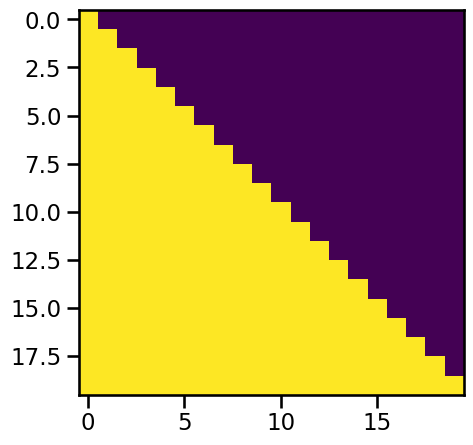

In [41]:
# Let's visualize what the target mask looks like
import seaborn
seaborn.set_context(context="talk")

plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0].numpy())

x = torch.arange(src_vocab_size).view(1, -1)
x = torch.cat((x, x), dim=0)
src_mask, tgt_mask = create_mask(x, x)
print(src_mask.shape, tgt_mask.shape)

### Prepare Data Loaders

In [42]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List


SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# # Create source and target language tokenizer. Make sure to install the dependencies.
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator 
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [43]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(
        token_transform[ln], #Tokenization
        vocab_transform[ln], #Numericalization
        tensor_transform # Add BOS/EOS and create tensor
    )


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch.transpose(0, 1), tgt_batch.transpose(0, 1)

In [44]:
BATCH_SIZE = 8

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

for idx, (src, tgt) in enumerate(train_dataloader):
    if idx > 2:
        break
    print('src: {}, tgt: {}'.format(src.shape, tgt.shape))

src: torch.Size([8, 18]), tgt: torch.Size([8, 17])
src: torch.Size([8, 20]), tgt: torch.Size([8, 19])
src: torch.Size([8, 18]), tgt: torch.Size([8, 19])


### <font size='4' color='red'>Task 4.4: Define the Model and Loss Function (3 points)</font>

In [48]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMBED_SIZE = 512
NUM_ATTN_HEADS = 8
FF_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

###########################################################################
# TODO: Define the model and loss function.                               #
# Note that this time we will generate tokens, where some of them in the  #
# training time are from paddings. We don't want to penalize the model    #
# if the output at such positions are wrong. You can use the              #
# `ignore_index` in a loss function to suppress loss computation if the   #
# ground-truth label is equal to the given value. Check here for          #
# more details https://pytorch.org/docs/stable/nn.html#loss-functions     #
###########################################################################

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMBED_SIZE, NUM_ATTN_HEADS, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FF_DIM)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
transformer = transformer.to(device)

optimizer = torch.optim.Adam(
    transformer.parameters(), 
    lr=0.0001, 
    betas=(0.9, 0.98), 
    eps=1e-9
)

### Model Training and Validation

In [49]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_iter_list = list(train_iter)
    train_dataloader = DataLoader(train_iter_list, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    for src, tgt in train_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask = create_mask(src, tgt_input)
        src_mask = src_mask.to(device)
        tgt_mask = tgt_mask.to(device)

        logits = model(src, tgt_input, src_mask, tgt_mask)

        optimizer.zero_grad()

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_iter_list = list(val_iter)
    val_dataloader = DataLoader(val_iter_list, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask)
        
        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

from timeit import default_timer as timer
NUM_EPOCHS = 10

# You should be able to get train loss around 1.5 and val loss around 2.2
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 5.929, Val loss: 5.043, Epoch time = 58.139s
Epoch: 2, Train loss: 4.608, Val loss: 4.303, Epoch time = 58.564s
Epoch: 3, Train loss: 4.116, Val loss: 4.028, Epoch time = 57.950s
Epoch: 4, Train loss: 3.707, Val loss: 3.710, Epoch time = 58.090s
Epoch: 5, Train loss: 3.381, Val loss: 3.563, Epoch time = 58.507s
Epoch: 6, Train loss: 3.129, Val loss: 3.363, Epoch time = 57.952s
Epoch: 7, Train loss: 2.738, Val loss: 3.074, Epoch time = 58.234s
Epoch: 8, Train loss: 2.454, Val loss: 2.976, Epoch time = 58.183s
Epoch: 9, Train loss: 2.271, Val loss: 2.925, Epoch time = 58.615s
Epoch: 10, Train loss: 2.113, Val loss: 2.906, Epoch time = 58.549s
